https://github.com/jmichaux/dqn-pytorch/blob/master/main.py

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import gym

import numpy as np
import random
from collections import namedtuple, deque
from itertools import count
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from src.utils.Config import Config
from src.utils.Logging import Logger
from src.utils.atari_wrappers import wrap_deepmind, make_atari

In [8]:
seed = 1234

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
# env    = wrap_deepmind(env)
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)

In [9]:
print("observation shape: {}".format(env.observation_space.shape))
print("Action space: {}".format(env.action_space.n))

observation shape: (84, 84, 4)
Action space: 6


### Parsing state from lazy frame to torch tensor

In [10]:
def parse_state(state):
    state = np.array(state).transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = state.unsqueeze(0).float() / 256
    return state

state = env.reset()
parse_state(state)

tensor([[[[0.2031, 0.2031, 0.2031,  ..., 0.3398, 0.3398, 0.3398],
          [0.3398, 0.3398, 0.3398,  ..., 0.3398, 0.3398, 0.3398],
          [0.3398, 0.3398, 0.3398,  ..., 0.3398, 0.3398, 0.3398],
          ...,
          [0.9219, 0.9219, 0.9219,  ..., 0.9219, 0.9219, 0.9219],
          [0.9219, 0.9219, 0.9219,  ..., 0.9219, 0.9219, 0.9219],
          [0.9219, 0.9219, 0.9219,  ..., 0.9219, 0.9219, 0.9219]],

         [[0.2031, 0.2031, 0.2031,  ..., 0.3398, 0.3398, 0.3398],
          [0.3398, 0.3398, 0.3398,  ..., 0.3398, 0.3398, 0.3398],
          [0.3398, 0.3398, 0.3398,  ..., 0.3398, 0.3398, 0.3398],
          ...,
          [0.9219, 0.9219, 0.9219,  ..., 0.9219, 0.9219, 0.9219],
          [0.9219, 0.9219, 0.9219,  ..., 0.9219, 0.9219, 0.9219],
          [0.9219, 0.9219, 0.9219,  ..., 0.9219, 0.9219, 0.9219]],

         [[0.2031, 0.2031, 0.2031,  ..., 0.3398, 0.3398, 0.3398],
          [0.3398, 0.3398, 0.3398,  ..., 0.3398, 0.3398, 0.3398],
          [0.3398, 0.3398, 0.3398,  ..., 0

### Testing out Network

In [11]:
class CNNQNetwork(nn.Module):
    def __init__(self, channel_in, action_size, seed, fc1_units=512):
        # Call inheritance
        super(CNNQNetwork, self).__init__()
        self.seed = torch.manual_seed(1234)
        
        self.conv_head = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, action_size),
        )
        
#         self.reset_parameters()
#     def reset_parameters(self):
#         self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
#         self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
#         self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = self.conv_head(state)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

# def hidden_init(layer):
#     fan_in = layer.weight.data.size()[0]
#     lim = 1. / np.sqrt(fan_in)
#     return (-lim, lim)


In [12]:
state = parse_state(env.reset())

conv_head = nn.Sequential(
    nn.Conv2d(4, 32, kernel_size=8, stride=4),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=4, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
)

conv_head(state).shape

torch.Size([1, 64, 7, 7])

In [13]:
model = CNNQNetwork(4, env.action_space.n, seed, 512)
model(state)

tensor([[ 0.0606,  0.1745,  0.0196,  0.1161, -0.2145,  0.1829]],
       grad_fn=<AddmmBackward>)

In [14]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, config):
        """Initialize a ReplayBuffer object.

        Params
        ======
        action_size (int): dimension of each action
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
        """

        self.memory = deque(maxlen=config.buffer_size)  
        self.batch_size = config.batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(config.seed)
        self.device = config.device

    def add(self, state, action, reward, next_state, done, error=0):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
#         pdb.set_trace()

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        weights = torch.ones(len(experiences)).float().to(self.device)
        memory_loc = torch.zeros(len(experiences)).float().to(self.device)

        return (states, actions, rewards, next_states, dones, weights, memory_loc)

    def n_entries(self):
        return len(self.memory)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [21]:
class Agent():
    def __init__(self, channel_in, action_size, config):
        """
        Initialize an Agent object.

        state_size (int): dimension of each state
        action_size (int): dimension of each action
        """

        if config.model is None:
            raise Exception("Please select a Model for agent")
        if config.memory is None:
            raise Exception("Please select Memory for agent") 

        self.config = config

        self.channel_in = channel_in
        self.action_size = action_size
        self.seed = random.seed(self.config.seed)

        # Q-Network
#         self.qnetwork_local = self.config.model(state_size, action_size, self.seed, 64, 64).to(self.config.device)
#         self.qnetwork_target = self.config.model(state_size, action_size, self.seed, 64, 64).to(self.config.device)

        self.qnetwork_local = CNNQNetwork(4, env.action_space.n, seed, 512).to(self.config.device)
        self.qnetwork_target = CNNQNetwork(4, env.action_space.n, seed, 512).to(self.config.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.config.lr)

        # Replay memory
        self.memory = self.config.memory(config)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
        # Keep 
        self.eps = self.config.eps_start
    
    def step(self, state, action, reward, next_state, done):
        state = self.parse_state(state)
        next_state = self.parse_state(next_state)
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done) 

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.config.learn_every

        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if self.memory.n_entries() > self.config.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.config.gamma)

    def anneal_eps(self):
        self.eps = max(self.config.eps_end, self.config.eps_decay*self.eps) 
    
    def parse_state(self, state):
        state = np.array(state).transpose((2, 0, 1))
        state = torch.from_numpy(state)
        state = state.unsqueeze(0).float() / 256
        return state
    
    def act(self, state, network_only=False):
        state = self.parse_state(state).to(self.config.device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        # Epsilon-greedy action selection
        if random.random() > self.eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, is_weights, idxs = experiences

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)


        # Get max action from network
        max_next_actions = self.get_max_next_actions(next_states)


        # Get max_next_q_values -> .gather("dim", "index")
        max_next_q_values = self.qnetwork_target(next_states).gather(1, max_next_actions)

        # Y^q
        Q_targets = rewards + (gamma * max_next_q_values * (1 - dones))

        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        # - Optimizer is initilaised with qnetwork_local, so will update that one.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.config.tau)
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def get_max_next_actions(self, next_states):
        '''
        Passing next_states through network will give array of all action values (in batches)
        eg: [[0.25, -0.35], [-0.74, -0.65], ...]
        - Detach will avoid gradients being calculated on the variables
        - max() gives max value in whole array (0.25)
        - max(0) gives max in dim=0 ([0.25, -0.35])
        - max(1) gives max in dim=1, therefore: two tensors, one of max values and one of index
        eg: 
        - values=tensor([0.25, -0.65, ...])
        - indices=tensor([0, 1, ...])
        - we'll want to take the [1] index as that is only the action
        eg: tensor([0, 1, ...]) 
        - unsqueeze allows us to create them into an array that is usuable for next bit (.view(-1,1) would also work)
        eg: eg: tensor([[0], [1], ...]) 
        '''
        return self.qnetwork_target(next_states).detach().max(1)[1].unsqueeze(1)

In [22]:
config = Config()

config.env = env

config.win_condition = 10000
n_episodes = 400
config.memory = ReplayBuffer
config.batch_size = 32
config.model = CNNQNetwork
config.print_config()

logger = Logger(config)

Agent Configuration:
env: 		EnvSpec(PongNoFrameskip-v4)
win condition: 	10000
device: 	cuda:0
seed: 		123456789
n_episodes: 	2000
max_t: 		1000
eps_start: 	1.0
eps_end: 	0.01
eps_decay: 	0.995
eps_greedy: 	True
noisy: 		False
tau: 		0.001
gamma: 		0.99
lr: 		0.0005
memory: 	<class '__main__.ReplayBuffer'>
batch_size: 	32
buffer_size: 	100000
lr_annealing: 	False
learn_every: 	4
double_dqn: 	False
model: 		<class '__main__.CNNQNetwork'>
save_loc: 	None
<_sre.SRE_Match object; span=(0, 27), match='EnvSpec(PongNoFrameskip-v4)'>
Logging at: logs/PongNoFrameskip-v4/experiment-2020-05-24_15_58_58


In [23]:
def train(config, logger):
    experiment_start = time.time()
    env = config.env
    frame = 0

    agent = Agent(channel_in=4, action_size=env.action_space.n, config=config)

    total_scores_deque = deque(maxlen=100)
    total_scores = []


    for i_episode in range(1, config.n_episodes+1):
        states = env.reset()
        scores = 0

        start_time = time.time()

        for t in count():
            actions = agent.act(states)
            next_states, rewards, dones, _ = env.step(np.array(actions))
            agent.step(states, actions, rewards, next_states,dones)



            states = next_states
            scores += rewards
            number_of_time_steps = t
            frame += 1

            if np.any(dones):
                break 

        agent.anneal_eps()


        # Book Keeping
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)

        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)

        logger.log_scalar("score", mean_score, i_episode)
        logger.log_scalar("average_score", total_average_score, i_episode)

        duration = time.time() - start_time

        # print('\rEpisode {}\tTotal Average Score (in 100 window): {:.4f}\tMean: {:.4f}\tMin: {:.4f}\tMax: {:.4f}\tDuration: {:.4f}\t#TimeSteps: {:.4f}'.format(i_episode, total_average_score, mean_score, min_score, max_score, duration, number_of_time_steps), end="")
        print('\rEpi: {}\t Frame: {} \tAverage: {:.4f}\tMean: {:.4f}\tDuration: {:.2f}\t#t_s: {:.1f}'.format(i_episode, frame, total_average_score, mean_score, duration, number_of_time_steps), end="")

        if i_episode % 100 == 0:
            print('\rEpi: {}\t Frame: {}\tAverage Score: {:.4f}\tMean: {:.4f}\tDuration: {:.2f}\t#t_s: {:.1f}'.format(i_episode, frame, total_average_score, mean_score, duration, number_of_time_steps))
            torch.save(agent.qnetwork_local.state_dict(), "{}/checkpoint.pth".format(logger.log_file_path, date=datetime.datetime.now()))
        if config.win_condition is not None and total_average_score > config.win_condition: 
            print("\nEnvironment Solved in {:.4f} seconds !".format(time.time() - experiment_start))
            torch.save(agent.qnetwork_local.state_dict(), "{}/checkpoint.pth".format(logger.log_file_path, date=datetime.datetime.now()))
            return 

    return

In [24]:
train(config, logger)

Epi: 100	 Frame: 95038	Average Score: -20.1400	Mean: -18.0000	Duration: 9.08	#t_s: 1064.0
Epi: 200	 Frame: 215265	Average Score: -18.6400	Mean: -18.0000	Duration: 10.16	#t_s: 1219.0
Epi: 300	 Frame: 362446	Average Score: -16.4100	Mean: -15.0000	Duration: 12.87	#t_s: 1533.0
Epi: 400	 Frame: 522902	Average Score: -14.5100	Mean: -20.0000	Duration: 9.28	#t_s: 1110.0
Epi: 500	 Frame: 705932	Average Score: -11.2700	Mean: 3.0000	Duration: 21.06	#t_s: 2510.0
Epi: 600	 Frame: 940220	Average Score: -4.1600	Mean: -7.0000	Duration: 17.90	#t_s: 2143.0
Epi: 700	 Frame: 1188962	Average Score: 4.8800	Mean: -1.0000	Duration: 22.94	#t_s: 2755.0
Epi: 800	 Frame: 1418125	Average Score: 10.1400	Mean: 9.0000	Duration: 19.41	#t_s: 2319.0
Epi: 900	 Frame: 1626455	Average Score: 14.2400	Mean: 17.0000	Duration: 15.88	#t_s: 1892.0
Epi: 1000	 Frame: 1817176	Average Score: 16.2200	Mean: 20.0000	Duration: 13.73	#t_s: 1649.0
Epi: 1100	 Frame: 2013092	Average Score: 16.0300	Mean: 13.0000	Duration: 18.20	#t_s: 2175.0


KeyboardInterrupt: 

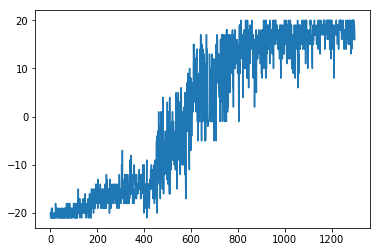

In [25]:
plt.plot(logger.score)

In [ ]:
watch(config, logger.log_file_path)